# TensorFlow FrequencyHough

This notebook shows a runnable example of the TensorFlow$^1$ porting of the FrequencyHough algorithm$^2$, which is an implementation of the so-called Hough transform$^3$ and the core and most computationally expensive part of the FrequencyHough data analysis pipeline for Continuous Waves search$^4$.
More documentation at the LIGO wiki page [FrequencyHoughTensorFlow](https://wiki.ligo.org/bin/edit/CW/FrequencyHoughTensorFlow).


## Contents <a id='contents'></a>

* [**References**](#references)
* [**Code**](#code)
    * [Defining parameters](#pars)
    * [Loading and managing data](#load)
    * [Defining the TensorFlow graph ](#graph)
    * [Feeding and running ](#run)
4. [**Example plots**](#plots)
5. [**Check with MATLAB code**](#checks)





## References <a id='references'></a>
1. [The TensorFlow Authors, *TensorFlow*, `www.tensorflow.org`, 2018.](www.tensorflow.org)
2. [Antonucci, F. et al., *Detection of periodic gravitational wave sources by
Hough transform in the f versus plane*, Classical and Quantum Gravity,
vol. 25.18, p. 184015, 2008.](http://iopscience.iop.org/article/10.1088/0264-9381/25/18/184015/meta)
3. [Hough, P. V. C., *Method and means for recognizing complex patterns*
U.S. Patent No. 3069654A, 1962.](https://patents.google.com/patent/US3069654)
4. [Astone, P. et al., *Method for all-sky searches of continuous gravitational
wave signals using the frequency-Hough transform*, Physical Review
D, vol. 90.4, p. 042002, 2014.](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.90.042002)



## Code <a id='code'></a> 
([Back](#contents))

In [7]:
import tensorflow as tf
import numpy
import scipy.io
import time

# open a tf session
sess = tf.Session()

# input file path
#dataPath = "../data/in_O2LL_01_0069_.mat"
#dataPath = "../data/in_O2LL_02_0367_.mat"
#dataPath = "../data/in_O2LL_03_0794_.mat"
dataPath = "../data/in_O2LL_04_1768_.mat"

# loading the input file (with the peakmap inside a matlab structure)
#WARNING at the moment the hough transform is parallelized only on a single peakmap
#TODO improve parallelization on multiple peakmaps (or use bigger peakmaps)
struct = scipy.io.loadmat(dataPath)['job_pack_0']

# defining the FFT length of the input file loaded
PAR_firstFreq = struct["basic_info"][0,0]["frin"][0,0][0,0]

if PAR_firstFreq < 2048:
    PAR_tFft = 1024.0
if PAR_firstFreq < 1024 :
    PAR_tFft = 2048.0
if PAR_firstFreq < 512:
    PAR_tFft = 4096.0
if PAR_firstFreq < 128:
    PAR_tFft = 8192.0
print(PAR_tFft)


1024.0


### Defining parameters <a id='pars'></a>
Here some key search parameters are defined.  
([Back](#contents))

In [17]:
# times
PAR_tObs = 9 #months
print(PAR_tObs)
PAR_tObs = PAR_tObs*30*24*60*60
PAR_epoch = (57722+57990)/2 

# frequencies
PAR_enhance = 10
PAR_stepFreq = 1/PAR_tFft
PAR_refinedStepFreq =  PAR_stepFreq/PAR_enhance

# spindowns
PAR_fdotMin = -1e-9
PAR_fdotMax = 1e-10
PAR_stepFdot = PAR_stepFreq/PAR_tObs
PAR_nstepFdot = numpy.round((PAR_fdotMax-PAR_fdotMin)/PAR_stepFdot).astype(numpy.int32)

# others
PAR_secbelt = 4000

1024.0
9


### Loading and managing data <a id='load'></a>
The peakmap is loaded and the spindown array defined.  
([Back](#contents))

In [18]:
# the address of the peakmap in the input file structure is job_pack_0.peaks
# the peakmap is espressed as a sparse matrix with 3 arrays, since the most part is 0: 
# row coordinates (times), column coordinates (frequencies), values (weights)

# times
times = struct['peaks'][0,0][0]
times = times-PAR_epoch
times = ((times)*60*60*24/PAR_refinedStepFreq)

# frequencies
freqs = struct['peaks'][0,0][1]
freqMin = numpy.amin(freqs)
freqMax = numpy.amax(freqs)
freqStart = freqMin- PAR_stepFreq/2 - PAR_refinedStepFreq
freqEnd = freqMax + PAR_stepFreq/2 + PAR_refinedStepFreq
nstepFreqs = numpy.ceil((freqEnd-freqStart)/PAR_refinedStepFreq)+PAR_secbelt
freqs = freqs-freqStart
freqs = (freqs/PAR_refinedStepFreq)-round(PAR_enhance/2+0.001)
 
# spindowns
spindowns = numpy.arange(0, PAR_nstepFdot)
spindowns = numpy.multiply(spindowns,PAR_stepFdot)
spindowns = numpy.add(spindowns, PAR_fdotMin)

# others
weights = (struct['peaks'][0,0][4]+1)

# once the data of the peakmap are rearranged as above, it's better to rejoin them in an unique array
peakmap = numpy.stack((times,freqs,weights),1)
spindowns = spindowns

# these two variables are only redifinition of old variable to clarify better the Hough transorm code
PAR_nRows = numpy.int32(PAR_nstepFdot)
PAR_nColumns = numpy.int32(nstepFreqs)

### Defining the TensorFlow graph <a id='graph'></a>
Core of the code: the actual TensorFlow implementation of the FrequencyHough algorithm.  
([Back](#contents))

In [19]:
# now let's use TensorFlow
# defining tf constants to the hough transform
# WARNING i'm using 64bit data for times because 9 months with a step of 4096s exceed 32bit precision, 
# this forces to use 64bit spindowns to run tf.matmul (tensorflow needs same data type tensors). 
# This slows a bit the code with a GPU capable to run 64bit calculations (eg Tesla series), 
# but can be a problem on other series (eg GeForce)
# TODO remove any 64bit data
# WARNING uncomment this for 64bit data
PAR_secbeltTF = tf.constant(4000,dtype = tf.float64, name = 'secur')
peakmapTF = tf.placeholder(tf.float64, name = 'inputPM')
spindownsTF = tf.placeholder(tf.float64, name = 'inputSD')
# WARNING comment this for 64bit data
#PAR_secbeltTF = tf.constant(4000,dtype = tf.float32, name = 'secur')
#peakmapTF = tf.placeholder(tf.float32, name = 'inputPM')
#spindownsTF = tf.placeholder(tf.float32, name = 'inputSD')

# calculating the Hough transofrm, with a fully vectorial tensorflow function with GPU parallelization
def frequencyHough(peakmapHM,spindownsHM):
	"""
	Computes the frequency-Hough transform of a sparse peakmap.
	Parameters:
	frequencies, times : 1D tensors
	The coordinates of the peakmap in sparse format.
	weights :  1D tensor
	The values of the peaks in the sparse peakmap.
	spindowns : 1D tensor
	The spindowns values over which calculate the Hough transform.
	Size of the Hough map
	Returns:
	houghMap : 2D tensor
	The Hough transform matrix
	"""

	def mapnonVar(ithStep):
		# this function computes the Hough transform histogram for a given spindown
		# WARNING the 64 bit precision slows the computation and could not be supported in many GPUs
		# TODO  remove any 64bit data
		sdTimed = tf.multiply(spindownsHM[ithStep], timesHM, name = "Tdotpert")
		# WARNING uncomment this for 64bit data (perhaps unnecessary cast)
		sdTimed = tf.cast(sdTimed, dtype = tf.float64)
		
		transform = tf.round(freqsHM-sdTimed+PAR_secbeltTF/2, name = "trasfFreq")
		transform = tf.cast(transform, dtype=tf.int32)
		# the rounding operation brings a some peaks in the same frequency-spindown bin in the Hough map
		# the left edge is then computed binning that peaks properly
		# (according to their values, if the peakmap was adactive)
		# the following is the core of the algoritm and brings the most computational effort
		values = tf.unsorted_segment_sum(weightsHM, transform, PAR_nColumns)
		# WARNING uncomment this for 64bit data
		values = tf.cast(values, dtype=tf.float32)
		return values


	timesHM = peakmapHM[:,0]
	freqsHM = peakmapHM[:,1]
	weightsHM = peakmapHM[:,2]

	# in order to save a graph and then loading it in another code,
	# here the hough map tensor is defined as a variable
	houghLeft = tf.Variable(tf.zeros([PAR_nRows,PAR_nColumns]),name = "var")
	# to keep under control the memory usage, the map function is a 
	# very useful tool to apply the same function over a vector
	# in this way the vectorization is preserved
	houghLeft = houghLeft.assign(tf.map_fn(mapnonVar, tf.range(0, PAR_nRows), dtype=tf.float32, parallel_iterations=8))

	# let's superimpose the right edge on the image
	leftStripe = tf.slice(houghLeft, [0,0], [houghLeft.get_shape()[0],10])
	houghRight = tf.subtract(tf.slice(houghLeft, [0,10],[houghLeft.get_shape()[0], houghLeft.get_shape()[1]-10]),
							 tf.slice(houghLeft, [0,0],[houghLeft.get_shape()[0], houghLeft.get_shape()[1]-10]))
	# now we have the so called differential hough map
	houghDiff = tf.concat([leftStripe,houghRight],1)
	# and at last we can cumulative sum along the rows to have the integral hough map
	houghMap = tf.cumsum(houghDiff, axis = 1, name = "output")
	return houghMap

FHMap = frequencyHough(peakmapTF, spindownsTF)

### Feeding and running <a id='run'></a>
Here the graph is simply executed, feeding the data to the graph through the placeholders.  
([Back](#contents))

In [20]:
# this is the dictionary with the data to be fed to the graph using placeholders
dataDict = { 
               peakmapTF: peakmap,
               spindownsTF : spindowns
             }
# initializing the variable
sess.run(tf.global_variables_initializer())
# running the graph
start = time.time()
image = sess.run(FHMap, feed_dict = dataDict)
stop = time.time()
print("execution time " + str(stop-start) + " s")

filename = ("check/mapTF%d.mat" % PAR_tFft)
scipy.io.savemat(filename,{"hough":image} )

execution time 6.429220199584961 s


## Example plots <a id='plots'></a>
A couple of plots showing the look of a Hough map.  
([Back](#contents))

<IPython.core.display.Javascript object>


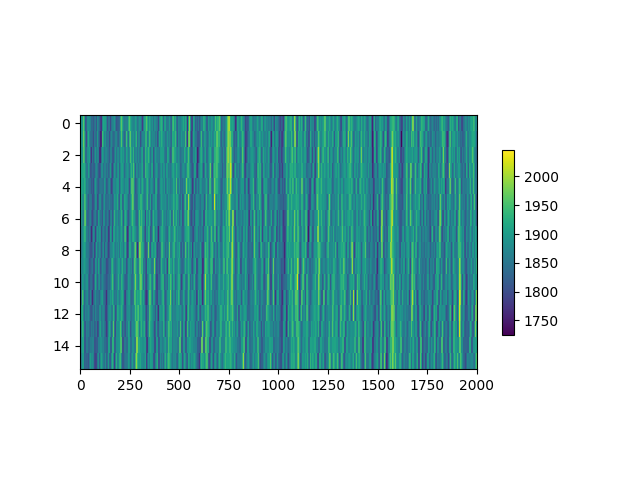

In [31]:
from matplotlib import pyplot
% matplotlib notebook
plotim = image[10:30,20000:22000]
a = pyplot.imshow(plotim, aspect = 80)
pyplot.colorbar(shrink = 0.5,aspect = 15)

<IPython.core.display.Javascript object>


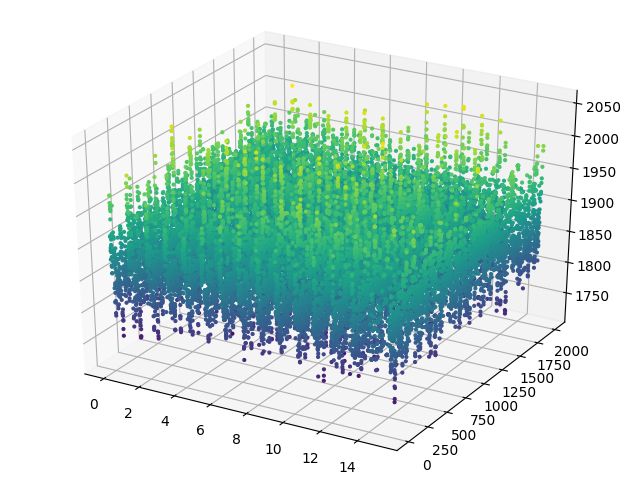

In [32]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

ind = numpy.where(plotim<1e6)
row = ind[0]
col = ind[1]
val = numpy.ravel(plotim)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(row, col, val, c = val, marker='o', s= 4, alpha = 1)

## Check with MATLAB code  <a id='checks'></a>
([Back](#contents))

In [8]:
import numpy
import scipy.io
from matplotlib import pyplot

pathMAT = ("check/mapMAT%d.mat" % PAR_tFft)
pathTF = ("check/mapTF%d.mat" % PAR_tFft)
print(pathTF)
mapMAT = scipy.io.loadmat(pathMAT)['hough']
mapTF = scipy.io.loadmat(pathTF)['hough']

# nonzero spots the non-zero pixel
# of the difference between the two matrices
# since the subtraction is element-wise,
# if empty, the two matrices are the same pixel-per-pixel
numpy.nonzero(mapMAT - mapTF)

check/mapTF1024.mat


(array([], dtype=int64), array([], dtype=int64))

<IPython.core.display.Javascript object>


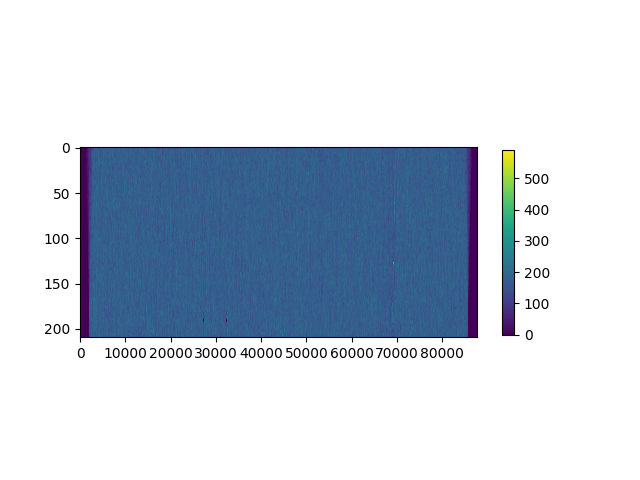

In [44]:
% matplotlib notebook
a = pyplot.imshow(mapMAT, aspect = 200)
pyplot.colorbar(shrink = 0.5,aspect = 15)

<IPython.core.display.Javascript object>


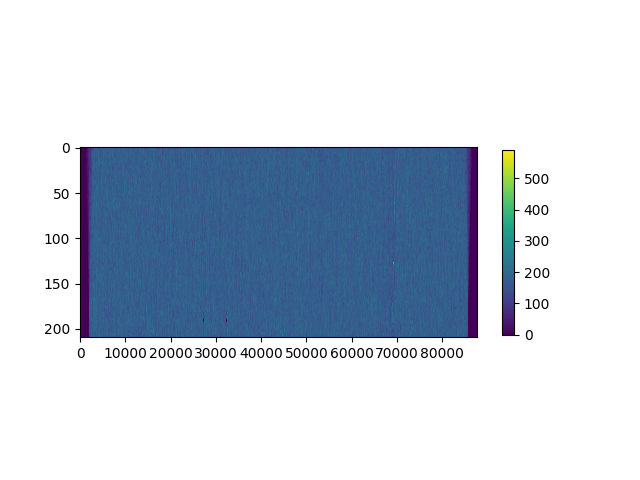

In [45]:
% matplotlib notebook
a = pyplot.imshow(mapTF, aspect = 200)
pyplot.colorbar(shrink = 0.5,aspect = 15)

<IPython.core.display.Javascript object>


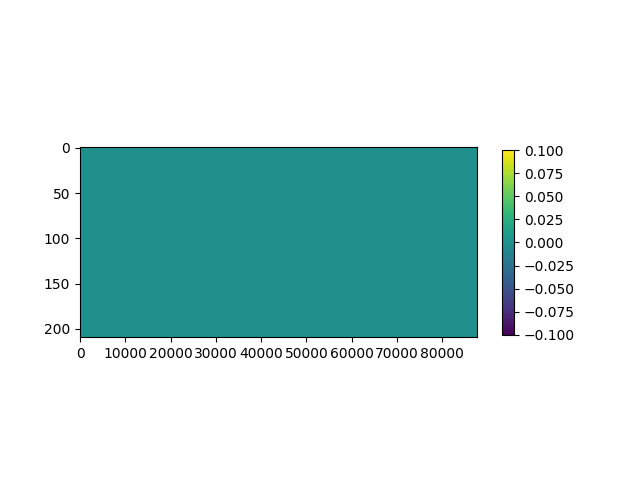

In [46]:
% matplotlib notebook
a = pyplot.imshow(mapMAT-mapTF, aspect = 200)
pyplot.colorbar(shrink = 0.5,aspect = 15)